In [1]:
import numpy as np
from matplotlib import pylab as plt
import struct
import pyaudio

def __clip(s):
    if s > 1.0:
        s = np.float16(1.0)
    if s < -1.0:
        s = np.float16(-1.0)
    return s

def sin(a, fs, f0, n, clip=True):
    s = a * np.sin(2.0 * np.pi * f0 * n / fs)
    if clip:
        s = __clip(s)
    return s 

def square(a, fs, f0, n, K=10, clip=True):
    s = np.sum([(a / (2 * k - 1) * np.sin((2 * k - 1) * 2 * np.pi * f0 * n / fs)) for k in range(1, K)])
    if clip:
        s = __clip(s)
    return s

def triangle(a, fs, f0, n, K=10, clip=True):
    s = np.sum([(-1) ** k * (a / (2*k + 1)**2) * np.sin((2*k + 1) * 2 * np.pi * f0 * n / fs) for k in range(K)])
    if clip:
        s = __clip(s)
    return s

def saw(a, fs, f0, n, K=10, clip=True):
    s =  np.sum([(a / k) * np.sin(2.0 * np.pi * k * n / fs * f0) for k in range(1, K)])
    if clip:
        s = __clip(s)
    return s

In [2]:
def p(method, a=1, fs=8000, f0=440, sec=1):
    swav = []
    for n in np.arange(fs * sec):
        s = method(a, fs, f0, n)
        swav.append(s)
    plt.plot(swav[0:100])
    plt.show()

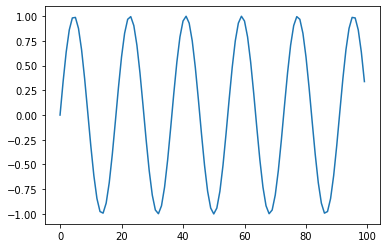

In [3]:
p(sin)

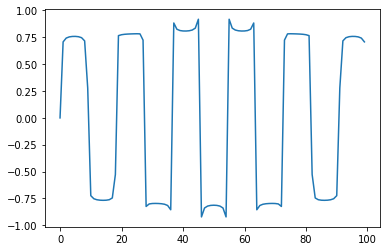

In [4]:
p(square)

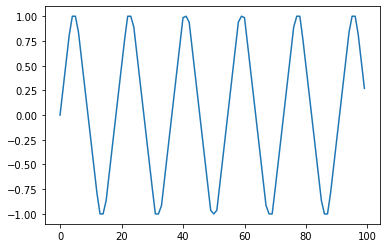

In [5]:
p(triangle)

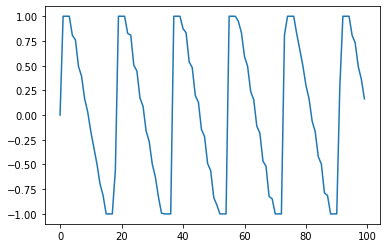

In [6]:
p(saw)

In [7]:
def make_binary(method, A=1, fs=8000, f0=440, sec=1):
    swav = []
    for n in np.arange(fs * sec):
        # make sin wave
        s = method(A, fs, f0, n)
        # to be signed 16bit integer
        s = (s * 32767.0).astype(np.int16)  # float to signed int16
        swav.append(s)
    binwave = struct.pack("h" * len(swav), *swav)  # h => type short
    return binwave

def play_binary(binwave, fs=8000, nchannels=1):
    bit = 16
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16,
                    channels=nchannels,
                    rate=int(fs),
                    output=True)
    chunk = 1024
    sp = 0 # pointer of play position
    data = binwave[sp:sp+chunk]
    while data != b"":
        stream.write(data)
        sp = sp + chunk
        data = binwave[sp:sp+chunk]
    stream.close()
    p.terminate()

In [8]:
def sample_play(method):
    freqList = [262, 294, 330, 349, 392, 440, 494, 523]
    b = b""
    for i in range(len(freqList)):
        if i == len(freqList):
            sec = 1.0
        else:
            sec = 0.5
        b += make_binary(method, f0=freqList[i], sec=sec)
    b += make_binary(method, f0=0, sec=1.)
    for f in freqList:
        b += make_binary(method, f0=f, sec=0.05)
        b += make_binary(method, f0=0, sec=0.05)
    b+=make_binary(method, f0=0, sec=1)
    play_binary(b)

In [9]:
sample_play(sin)
sample_play(square)
sample_play(triangle)
sample_play(saw)